In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

# Box's Loop - Iteration 2

In [2]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)

## Model: GLM with Polynomial Basis Function

Moving on in the direction of Gaussian Processes, we would like to begin exploring basis functions. We will begin with a simple polynomial basis function, which is essentially a special case of multiple linear regression. Now we have the following mode:

$$f(\phi(X)) = \phi(X)^Tw$$
$$y = f(\phi(X)) + b$$

Where $\phi$ is the polynomial basis function. 

*We manually explored several polynomial degrees settling on a degree 4 polynomial.*

Where $X$ is the data, $w$ is a vector of weights, and $y$ is the prediction.

We construct the model as follows:

*Normal Prior $w$* = *p(w)* = $N(w\ |\ 0,\ \sigma^2_w I)$

*Normal Prior $b$* = *p($b$)* = $N(b\ |\ 0,\ \sigma^2_b)$

*Likelihood* = *p(y | w, $b$, $\phi(X)$)* = $\prod^N_{n=1} N(y_n\ |\ \phi(X)^Tw,\ \sigma^2_n)$

*Posterior* = $p(w,\ b\ |\ y,\ \phi(X)) \approx p(y\ |\ w,\ b,\ \phi(X))\ p(w)\ p(b)$

In [20]:
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]

x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.2, indicator_cols, y_cols)

x_train_standardized = data.standardize_cols(x_train_raw)
x_test_standardized = data.standardize_cols(x_test_raw)

poly_degree = 2

x_train = basis_functions.polynomial(x_train_standardized, degree=poly_degree)
x_test = basis_functions.polynomial(x_test_standardized, degree=poly_degree)

vis = x_train_raw.copy(deep=True)
vis["trip_duration"] = y_train_raw.copy(deep=True)

In [21]:
N, D = x_train.shape
X = tf.placeholder(tf.float32, [N, D])
w = ed.models.Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = ed.models.Normal(loc=[0.0], scale=1.0)
Y = ed.models.Normal(loc=ed.dot(X, w) + b, scale=[1.0])

# Inference

Again, we will use KLqp inference

In [22]:
qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb},# alpha: qalpha},
                    data={X: x_train.as_matrix(),
                          Y: np.reshape(y_train_raw.as_matrix(), (y_train_raw.shape[0]))})
inference.run(n_iter=3000)

3000/3000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 5790.156


# Criticism

The graph below is a showing our training data **orange** vs samples from our predictive distribution **blue**.

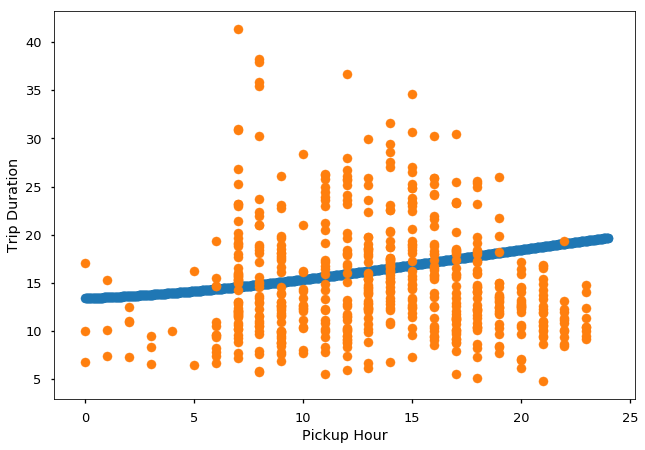

In [18]:
visualizations.vis_glm_poly(1000, poly_degree, indicator_cols, vis, qw, qb)

### Mean Absolute Error

The mean absolute error has improved our model. Specifically, our error has shrunk by just under one minute.

**MAE GLM:** ~3.60

**MAE Poly GLM:** ~3.02


In [23]:
N, D = x_test.shape
X_eval = tf.placeholder(tf.float32, [N, D])
y_posterior_predictive = ed.models.Normal(loc=ed.dot(X_eval, qw) + qb, scale=[1.0])
print(ed.evaluate("mean_absolute_error",
            data={X_eval: x_test.as_matrix(),
                  y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))},
             output_key=y_posterior_predictive))

3.01603


### Posterior Predictive Checks

Now, in order to get a better understanding as to the validity of our model, specifically the data generating process we will use posterior predictive checks. Posterior predictive checks allow us to simulate data from our fitted model (posterior) and compare results with the real data. While it does not tell us if our model is "good", discrepancies can tell us if the model makes sense. 

**Mean:** The mean lies in a region of high probabilities density. It does not indicate anything abnormal

**Min:** The minimum lies in a lower region of the sample distribution but not abnormally.

**Max:** The maximum lies far away from the distribution.

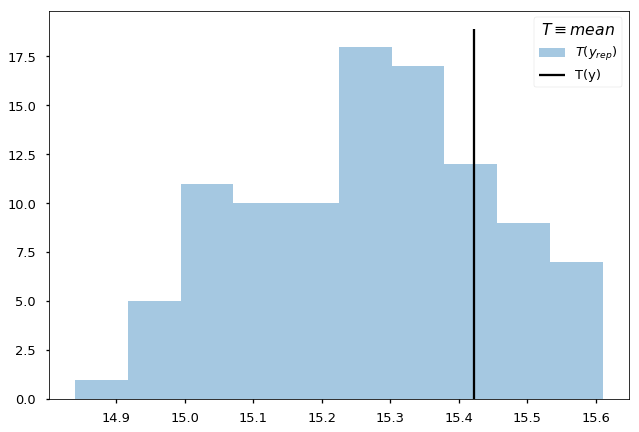

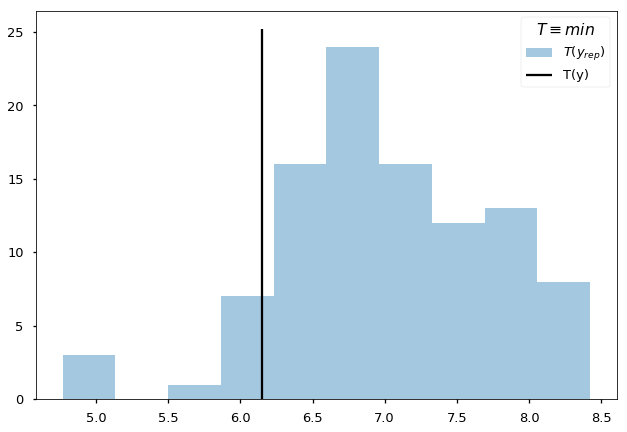

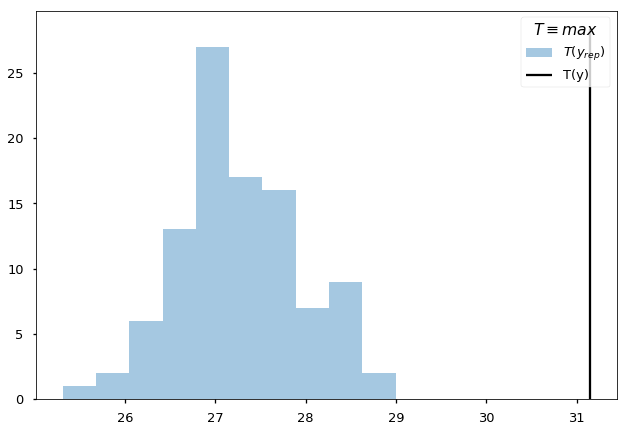

In [50]:
def T_max(data_dict, latent_vars_dict):
    return tf.reduce_max(data_dict[y_posterior_predictive])
def T_min(data_dict, latent_vars_dict):
    return tf.reduce_min(data_dict[y_posterior_predictive])
def T_mean(data_dict, latent_vars_dict):
    return tf.reduce_mean(data_dict[y_posterior_predictive])
ppc_stats_max = ed.ppc(T_max,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb }
                      )
ppc_stats_min = ed.ppc(T_min,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb }
                      )
ppc_stats_mean = ed.ppc(T_mean,
                             data={
                                 X_eval: x_test.as_matrix(),
                                 y_posterior_predictive: np.reshape(y_test_raw.as_matrix(), (y_test_raw.shape[0]))
                             },
                       latent_vars={w: qw, b: qb }
                      )

ed.ppc_stat_hist_plot(ppc_stats_mean[1][1], ppc_stats_mean[0], stat_name=r'$T \equiv mean$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_min[1][1], ppc_stats_min[0], stat_name=r'$T \equiv min$',
    bins=10)
plt.show()
ed.ppc_stat_hist_plot(ppc_stats_max[1][1], ppc_stats_max[0], stat_name=r'$T \equiv max$',
    bins=10)
plt.show()
